In [ ]:
import os
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow.keras.layers as layers

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import f1_score

from collections import Counter

#set tensorflow global options
tf.config.run_functions_eagerly(True)
AUTOTUNE = tf.data.AUTOTUNE

To work with the CervAI folder within collab, it is necessary to add the CervAI folder as your shortcut to your own personal drive.

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#set path to cervAI folder shortcut within local gdrive
project_folder = os.path.join('content/drive/MyDrive','cerv_AI')
project_folder = '/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi'
#set working directory to project/data folder
#os.chdir(project_folder)
data_folder = os.path.join(project_folder,'Data')
raw_data_folder = os.path.join(project_folder,'Data/raw')
os.chdir(raw_data_folder)

In [ ]:
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw'

# Unzipping datasets if needed:

In [ ]:
for file in os.listdir(os.getcwd()):
  if file[-4:] == '.zip': #only look at .zip files
    if file.split('.')[0] not in os.listdir(): #check if unzipped folder already exists
      file_path_to_unzip = os.path.join(os.getcwd(), file) #get path to zip file
      unzipped_file_path = os.path.join(os.getcwd(),file.split('.')[0]) #create new filepath for unzipped
      !unzip $file_path_to_unzip -d $unzipped_file_path #unzip folder
      print(f'{file} unzipped successfully')
    else: 
        print(f'{file} already unzipped')


cervix_93.zip already unzipped
cric_cropped.zip already unzipped
mendeley_hussain_liquid_based_cytology.zip already unzipped
CRIC_FullSlide_dataset.zip already unzipped


# Configure ML Flow details

In [ ]:
# !pip install git+https://github.com/mlflow/mlflow@master
!pip install mlflow
import mlflow
from getpass import getpass

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.0 MB 32.3 MB/s 
     |████████████████████████████████| 209 kB 69.2 MB/s 
     |████████████████████████████████| 181 kB 72.8 MB/s 
     |████████████████████████████████| 81 kB 10.0 MB/s 
     |████████████████████████████████| 146 kB 67.7 MB/s 
     |████████████████████████████████| 79 kB 9.1 MB/s 
     |████████████████████████████████| 596 kB 74.4 MB/s 
     |████████████████████████████████| 78 kB 8.6 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 59 kB 8.0 MB/s 
  Created wheel for databricks-cli: filename=databricks_cli-0.17.2-py3-none-any.whl size=143915 sha256=b415dd9b858bff870856ba9a53ec6f4ce5443e5027883fc1470175070848c176
  Stored in directory: /root/.cache/pip/wheels/e4/94/af/ed16e5ddf301a3628d1d3e15ef95bbb79e076a3be48c11699

In [ ]:
MLFLOW_TRACKING_URI='https://dagshub.com/Omdena/Drcadx.mlflow'
os.environ['MLFLOW_TRACKING_USERNAME'] = 'l.s.hamnett'
os.environ['MLFLOW_TRACKING_PASSWORD'] = getpass('Enter your DAGsHub access token or password: ')
mlflow.tensorflow.autolog()

Enter your DAGsHub access token or password: ··········


# Define common file handlers/help functions for all datasets

In [ ]:
#create balanced dataset
def create_balanced_bin_ds(file_path_array , bin_label_array):
  #split filepaths into two arrays, one with 0 labels , one with 1 labels
  file_path_indices_ones = np.reshape(np.where(new_labels==1),(-1)).astype(int) #create array of indices where label = 1 , 
  # print('file_path_indices_ones ', file_path_indices_ones)
  file_path_ones = file_path_array[file_path_indices_ones] #make array of filepaths where label = 1
  # print('file_path_ones ', file_path_ones)
  file_path_indices_zeroes = np.reshape(np.where(new_labels==0),(-1)).astype(int) #create array of indices where label =  , 
  # print('file_path_indices_zeroes ', file_path_indices_zeroes)
  file_path_zeroes = file_path_array[file_path_indices_zeroes] #make array of filepaths where label = 1
  # print('file_path_ones ', file_path_ones)


  #upsample the lowest number
  if len(file_path_ones) > len(file_path_zeroes):
    # zeroes is less so upsample zeroes to match number of ones
    biggest = 'ones'
    upsampled_zero_paths = np.random.choice(file_path_zeroes,len(file_path_ones),replace=True)
    upsampled_labels = np.zeros(len(upsampled_zero_paths)) #create new array with upsampled 0 labels
    file_path_ones_labels = np.ones(len(file_path_ones)) #make new array with 1 labels

    #join zero and one array back together
    all_file_paths_upsampled = np.concatenate((upsampled_zero_paths,file_path_ones),axis=0) 
    all_labels_upsampled = np.concatenate((upsampled_labels,file_path_ones_labels),axis=0)
  else:
    # ones is less so upsample ones to match number of ones
    biggest = 'zeroes'
    upsampled_one_paths = np.random.choice(file_path_ones,len(file_path_zeroes),replace=True)
    upsampled_labels = np.ones(len(upsampled_one_paths)) #create new array with upsampled 0 labels
    file_path_zeroes_labels = np.zeros(len(file_path_zeroes)) #make new array with 1 labels

     #join zero and one array back together
    all_file_paths_upsampled = np.concatenate((upsampled_one_paths,file_path_zeroes),axis=0) 
    all_labels_upsampled = np.concatenate((upsampled_labels,file_path_zeroes_labels),axis=0)
   


  #shuffle
  all_file_paths_upsampled_shuff, all_labels_upsampled_shuff = shuffle(all_file_paths_upsampled,all_labels_upsampled)

  #check has worked correctly
  for x in range(10):
    print(f'{all_file_paths_upsampled_shuff[x]}   {all_labels_upsampled_shuff[x]} ')

  print('upsampling completed')
  return all_file_paths_upsampled_shuff, all_labels_upsampled_shuff

In [ ]:
#define functions to turn list of file names and labels into a tensorflow dataset
def parse_image(filename):
  
    image1 = tf.io.read_file(filename) #read filename
    image2 = tf.io.decode_png(image1, channels=0) #convert from png greyscale
    image3 = tf.image.resize(image2,[90,90])
    return image3 

#wrap parse image function as tensorflow function for opimisation
def tf_parse_image(input):
  y = tf.numpy_function(parse_image, [input],tf.float32) 
  return y 

#create tf dataset
def create_tf_dataset(filepaths,labels):
  filenames_ds = tf.data.Dataset.from_tensor_slices(filepaths)
  images_ds = filenames_ds.map(lambda x: parse_image(x), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  labels_ds = tf.data.Dataset.from_tensor_slices(labels)
  ds_out = tf.data.Dataset.zip((images_ds, labels_ds))
  #ds_out = tf.data.Dataset.from_tensor_slices((images_ds, labels_ds))
  return ds_out

#we can speed up image loading by optimising the back-end processes
def configure_for_performance(ds,batch_size):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=200)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

#create optimised tf datasets
def make_tf_datasets(x_train,y_train,x_val,y_val,x_test,y_test,BATCH_SIZE):
  '''
  inputs: takes x inputs as list of filepaths , y inputs as associated image label, and batch_size
  returns: optimised tensorflow datasets to be loaded into ML model
  '''
  train_ds = create_tf_dataset(x_train,y_train)
  train_ds_opt = configure_for_performance(train_ds,BATCH_SIZE)
  valid_ds = create_tf_dataset(x_val,y_val)
  valid_ds_opt = configure_for_performance(valid_ds,BATCH_SIZE)
  if (x_test == None) or (y_test ==None):
    return train_ds_opt , valid_ds_opt
  else:
    test_ds_opt = create_tf_dataset(x_test,y_test)
    return train_ds_opt ,valid_ds_opt, test_ds_opt


In [ ]:
def make_train_test_splits(file_paths,labels,upsample=False):
  if upsample == True:
    new_file_paths , new_labels = create_balanced_bin_ds(file_paths,labels)
  else:
    new_file_paths = file_paths
    new_labels = labels

  x_train, x_val_test, y_train, y_val_test = train_test_split(new_file_paths, new_labels, train_size = 0.8, random_state=42, shuffle=True)
  x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, train_size = 0.5, random_state=42, shuffle=True)

  print(len(x_train))
  print(len(y_train))
  print(len(x_val))
  print(len(y_val))
  print(len(x_test))
  print(len(y_test))
  
  print('count labels in each set:')
  for item in [y_train,y_val,y_test]:
    count_classes(item)

  print('train val test splits created')
  return x_train, y_train, x_val, y_val, x_test, y_test

In [ ]:
#helper functions
#show how NN training is going
#given list of labels, return count of class values
def count_classes(label_array):
  label_list = label_array.flatten().tolist()
  print('total images = ',len(label_list))
  print(Counter(label_list))

#checking created datasets
#view 10 images from training set
def view_train_images(train_ds):
  for images,labels in train_ds.unbatch().take(10):
    print(tf.shape(images))
    print('label ',labels)
    # print(images)
    # img = mpimg.imread(images)
    plt.figsize = (20,20)
    images = images.numpy().astype('int')
    if tf.shape(images)[2] == 3: #3rd dimension = 3 , eg colours
      plt.imshow(images[:,:,:] ,vmin=0, vmax=255)
    elif tf.shape(images)[2] ==1: #3rd dimension = 1 grayscale
      #drop colour dimension
      images = images.reshape(90,90)
      plt.imshow(images[:,:] ,vmin=0, vmax=255,cmap='gray')
    plt.show()

#check batched data has expected dimensions:
def check_batch_dims(opt_ds):
  for image_batch, labels_batch in opt_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break #break after 1 batch

In [ ]:
# define/compile model
def define_compile_train_model(train_ds_opt,valid_ds_opt):
  #define model input dims
  img_height = 90
  img_width = 90

  #define model architecture
  model = tf.keras.models.Sequential([
    layers.Rescaling(scale=1./255, input_shape=(img_height,img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1,activation='sigmoid')
  ])

  print(model.summary())

  #reset backend so we don't have training data from previous experiments/runs
  tf.keras.backend.clear_session()

  #compile model
  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])
  
  #define early stopping callback
  #if val accuracy decreases 3 times, we are probably overfitting on training data
  callback1 = tf.keras.callbacks.EarlyStopping(
      monitor='val_accuracy', patience=3, verbose=0, mode='auto',
      baseline=None, restore_best_weights=True) 
  
  #train model
  EPOCHS=10

  history = model.fit(
    train_ds_opt,
    validation_data=valid_ds_opt,
    epochs=EPOCHS,
    verbose=2,
    callbacks=callback1)
  
  return model, history

In [ ]:
#evaluate how the training went
def show_training_metrics():
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(loss))

  plt.figure(figsize=(8, 8))
  # plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.show()

  # plt.subplot(1, 2, 2)
  plt.figure(figsize=(8, 8))
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

  print('Best val acc: ',max(val_acc))

#make predictions on validation set and return metrics
def eval_val_get_preds(valid_ds):
  predictions = []
  labels = []
  for image, label in valid_ds:
    temp_preds = np.round(model.predict(image),0).astype(int) #make predictions on image , round probabilitiess to 0 or 1 pred label
    predictions.append(temp_preds.flatten())
    temp_labels = label.numpy()
    labels.append(temp_labels.flatten())

  predicts_array = np.concatenate(predictions).ravel()
  labels_array = np.concatenate(labels).ravel()

  # #we construct a confusion matrix
  cm1 = cm(labels_array, predicts_array)
  print(cm1)

  # #we add some colours and labels for easier interpretation
  fig = plt.figure(figsize=(6,6))
  ax = fig.add_subplot(111)
  plt.title('Confusion matrix of the binary classifier')
  sns.heatmap(cm1,annot=True,fmt='.3g',cmap='Oranges')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

  #f1 score
  print(f'F1 score: {f1_score(labels_array,predicts_array)}'.format('3f'))

# Binary classification CRIC_cropped

In [ ]:
#set data directory paths
cric_cropped_2_class_dir = os.path.join(raw_data_folder,'cric_cropped/cric_cropped',"Base balanceada dividida","2 classes")
os.chdir(cric_cropped_2_class_dir)
train_dir = os.path.join(cric_cropped_2_class_dir,'Treino')
valid_dir = os.path.join(cric_cropped_2_class_dir,'Validacao')
test_dir = os.path.join(cric_cropped_2_class_dir,'Teste')

In [ ]:
#get paths to images and associated labels

def get_files_labels(input_dir):
    image_paths = [] #empty list to store filepaths
    labels = [] # empty list to store image labels
    #labels_zero = [0]*10 # initialise array of zeros, so we can use this to apply one-hot encoding to the image labels

    for root, dirnames, filenames in os.walk(input_dir): #look at all folders and subfolders and get the filenames
        for filename in filenames: #loop through filenames
          temp_path = os.path.join(root,filename) # temp filepath
          image_paths.append(temp_path) # add to image paths list
          # if looking at other datasets, below line needs to be modified to get image label from filepath
          temp_label = filename.split('_')[1] #
          labels.append(temp_label) # add label to label list

      #convert list into array
    labels_array = np.array(labels)
    labels_array = labels_array.astype(int)
    return image_paths, labels_array


x_train, y_train = get_files_labels(train_dir)
x_val, y_val = get_files_labels(valid_dir)


print('training images:')
count_classes(train_labels)

print('valid images:')
count_classes(valid_labels)


training images:
total images =  5514
Counter({0: 2758, 1: 2756})
valid images:
total images =  1381
Counter({0: 692, 1: 689})


In [ ]:
train_ds_opt , val_ds_opt = make_tf_datasets(x_train,y_train,x_val,y_val,x_test=None,y_test=None,BATCH_SIZE = 32)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(1, shape=(), dtype=int64)


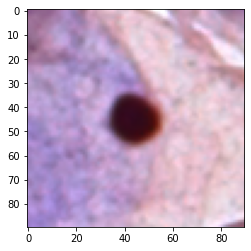

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(1, shape=(), dtype=int64)


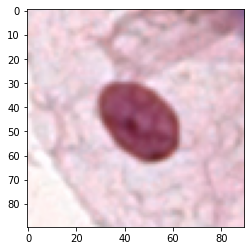

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(0, shape=(), dtype=int64)


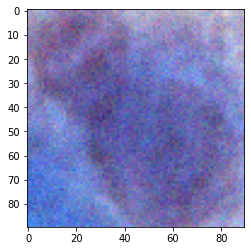

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(0, shape=(), dtype=int64)


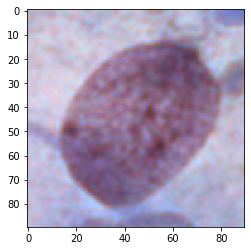

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(1, shape=(), dtype=int64)


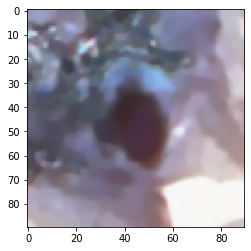

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(0, shape=(), dtype=int64)


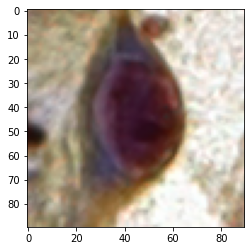

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(0, shape=(), dtype=int64)


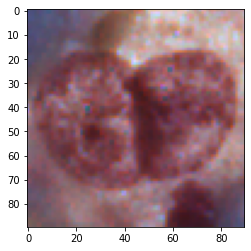

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(1, shape=(), dtype=int64)


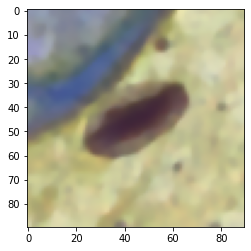

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(0, shape=(), dtype=int64)


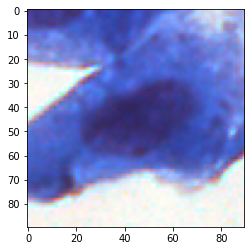

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(1, shape=(), dtype=int64)


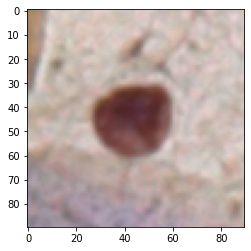

(32, 90, 90, 3)
(32,)


In [ ]:
view_train_images(train_ds_opt)
check_batch_dims(train_ds_opt)

In [ ]:
model, history = define_compile_train_model(train_ds_opt,valid_ds_opt)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 90, 90, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 90, 90, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 64)        1

2022/08/17 15:45:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7e121f931a874d9da5096e058b104ad9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
31/31 - 61s - loss: 0.6582 - accuracy: 0.6313 - val_loss: 0.5833 - val_accuracy: 0.6721 - 61s/epoch - 2s/step
Epoch 2/10
31/31 - 1s - loss: 0.4870 - accuracy: 0.7487 - val_loss: 0.3683 - val_accuracy: 0.8197 - 708ms/epoch - 23ms/step
Epoch 3/10
31/31 - 1s - loss: 0.2390 - accuracy: 0.8999 - val_loss: 0.1590 - val_accuracy: 0.9344 - 712ms/epoch - 23ms/step
Epoch 4/10
31/31 - 1s - loss: 0.1091 - accuracy: 0.9683 - val_loss: 0.0585 - val_accuracy: 0.9754 - 734ms/epoch - 24ms/step
Epoch 5/10
31/31 - 1s - loss: 0.0778 - accuracy: 0.9683 - val_loss: 0.1178 - val_accuracy: 0.9180 - 670ms/epoch - 22ms/step
Epoch 6/10
31/31 - 1s - loss: 0.0626 - accuracy: 0.9785 - val_loss: 0.0533 - val_accuracy: 0.9754 - 692ms/epoch - 22ms/step
Epoch 7/10
31/31 - 1s - loss: 0.0512 - accuracy: 0.9826 - val_loss: 0.0273 - val_accuracy: 0.9836 - 704ms/epoch - 23ms/step
Epoch 8/10
31/31 - 1s - loss: 0.0160 - accuracy: 0.9969 - val_loss: 0.0076 - val_accuracy: 1.0000 - 695ms/epoch - 22ms/step
Epoch 9/10


2022/08/17 15:46:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


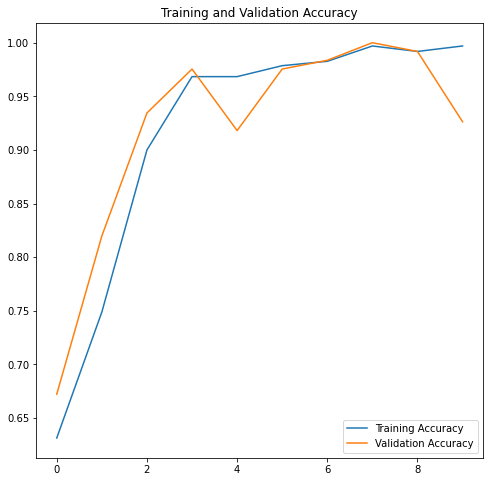

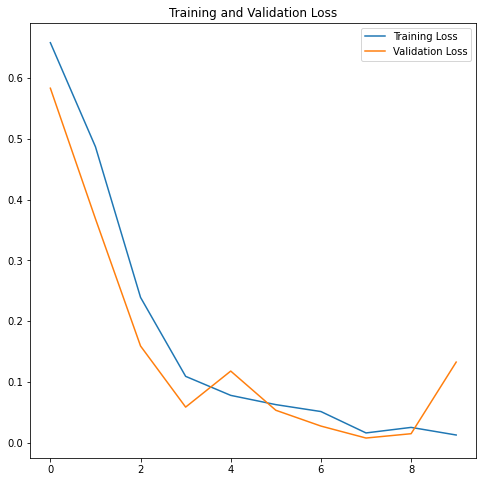

Best val acc:  1.0


In [ ]:
show_training_metrics()

[[64  0]
 [ 9 49]]


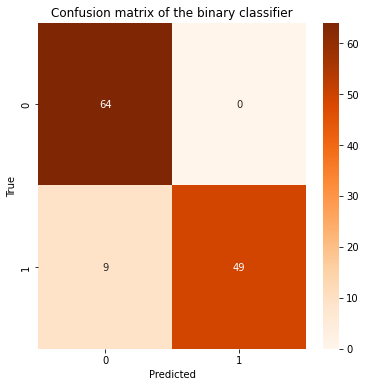

F1 score: 0.9158878504672897


In [ ]:
eval_val_get_preds(valid_ds_opt)

# Binary Classification CRIC full

In [ ]:
#set data directory paths
cric_full_2_class_dir = os.path.join(raw_data_folder,'CRIC_FullSlide_dataset/CRIC_FullSlide_dataset/')

In [ ]:
#get paths to images and associated labels

def get_files_labels(input_dir):
    image_paths = [] #empty list to store filepaths
    labels = [] # empty list to store image labels
    #labels_zero = [0]*10 # initialise array of zeros, so we can use this to apply one-hot encoding to the image labels

    for root, dirnames, filenames in os.walk(input_dir): #look at all folders and subfolders and get the filenames
        for filename in filenames: #loop through filenames
          temp_path = os.path.join(root,filename) # temp filepath
          image_paths.append(temp_path) # add to image paths list
          # if looking at other datasets, below line needs to be modified to get image label from filepath
          temp_label = filename.split('_')[0] #
          labels.append(temp_label) # add label to label list

      #convert list into array
    labels_array = np.array(labels)
    # labels_array = labels_array.astype(int)
    return image_paths, labels_array


all_image_paths , all_image_labels = get_files_labels(cric_full_2_class_dir)

print('all images:')
count_classes(all_image_labels)


all images:
total images =  400
Counter({'LSIL': 165, 'ASC-US': 101, 'NILM': 59, 'ASC-H': 30, 'HSIL': 24, 'SCC': 21})


In [ ]:
#create new labels
def label_mapping(x):
  if x == 'NILM':
    return 0
  else:
    return 1

def convert_labels(label_list):
  vf = np.vectorize(label_mapping)
  new_label_list = vf(label_list).astype(int)
  return new_label_list

new_labels = convert_labels(all_image_labels)
count_classes(new_labels)
#sanity check
# for x in range(len(all_image_paths)):
#   print(f'{all_image_paths[x].split("/")[-1]}     {new_labels[x]}')


total images =  400
Counter({1: 341, 0: 59})


In [ ]:
#separate file paths into two arrays of filepaths where label = 0 and another where label = 1
file_paths_array= np.array(all_image_paths) #convert python list of filepaths into nd array
print(f'total n paths: {len(file_paths_array)}') 
file_path_indices_ones = np.nonzero(new_labels) #seems redundant? - gets array of indices where new_labels == 1
file_path_ones = file_paths_array[file_path_indices_ones] #make new array from elements of file path array where elem = 1
print(len(file_path_ones))
print(file_path_ones[0:10])

new_labels_zeroes = np.where(new_labels==0) #return array where if label is 0 return 1 , else if label is 1 return 0
file_path_zeroes = file_paths_array[new_labels_zeroes]
print(len(file_path_zeroes))
print(file_path_zeroes[0:10])



total n paths: 400
341
['/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/CRIC_FullSlide_dataset/CRIC_FullSlide_dataset/LSIL_307.png'
 '/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/CRIC_FullSlide_dataset/CRIC_FullSlide_dataset/LSIL_8.png'
 '/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/CRIC_FullSlide_dataset/CRIC_FullSlide_dataset/ASC-US_13.png'
 '/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/CRIC_FullSlide_dataset/CRIC_FullSlide_dataset/SCC_99.png'
 '/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/CRIC_FullSlide_dataset/CRIC_FullSlide_dataset/ASC-US_236.png'
 '/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/CRIC_FullSli

In [ ]:
#upsample image paths with label 0
upsampled_zero_paths = np.random.choice(file_path_zeroes,len(file_path_ones),replace=True) #from list of filepaths with 0 label, keep choosing until we get the same no as images with 1 label 
len(upsampled_zero_paths)
upsampled_labels = np.zeros(len(upsampled_zero_paths)) #create array of zeros to be new label array for zero images
file_path_ones_labels = np.ones(len(file_path_ones)) #create array of ones to be new labael array for one images

all_file_paths_upsampled = np.concatenate((upsampled_zero_paths,file_path_ones),axis=0)
all_labels_upsampled = np.concatenate((upsampled_labels,file_path_ones_labels),axis=0)


all_file_paths_upsampled_shuff, all_labels_upsampled_shuff = shuffle(all_file_paths_upsampled,all_labels_upsampled)

#check that labels are correct
for x in range(10):
  print(f'{all_file_paths_upsampled_shuff[x]}   {all_labels_upsampled_shuff[x]} ')


/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/CRIC_FullSlide_dataset/CRIC_FullSlide_dataset/LSIL_195.png   1.0 
/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/CRIC_FullSlide_dataset/CRIC_FullSlide_dataset/NILM_146.png   0.0 
/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/CRIC_FullSlide_dataset/CRIC_FullSlide_dataset/NILM_102.png   0.0 
/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/CRIC_FullSlide_dataset/CRIC_FullSlide_dataset/ASC-US_268.png   1.0 
/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/CRIC_FullSlide_dataset/CRIC_FullSlide_dataset/LSIL_361.png   1.0 
/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/CRIC_FullSlide

In [ ]:
#split into train/val/test splits
def make_train_test_splits(file_paths,labels,upsample=False):
  if upsample == True:
    new_file_paths , new_labels = create_balanced_bin_ds(file_paths,labels)
  else:
    new_file_paths = file_paths
    new_labels = labels

  x_train, x_val_test, y_train, y_val_test = train_test_split(new_file_paths, new_labels, train_size = 0.8, random_state=42, shuffle=True)
  x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, train_size = 0.5, random_state=42, shuffle=True)

  print(len(x_train))
  print(len(y_train))
  print(len(x_val))
  print(len(y_val))
  print(len(x_test))
  print(len(y_test))
  for item in [y_train,y_val,y_test]:
    count_classes(item)

  return x_train, y_train, x_val, y_val, x_test, y_test


545
545
68
68
69
69
total images =  545
Counter({0.0: 274, 1.0: 271})
total images =  68
Counter({1.0: 36, 0.0: 32})
total images =  69
Counter({0.0: 35, 1.0: 34})


In [ ]:
#create datasets
def make_tf_datasets(x_train,y_train,x_val,y_val,x_test,y_test,BATCH_SIZE):
  train_ds = create_tf_dataset(x_train,y_train)
  train_ds_opt = configure_for_performance(train_ds,BATCH_SIZE)
  valid_ds = create_tf_dataset(x_val,y_val)
  valid_ds_opt = configure_for_performance(valid_ds,BATCH_SIZE)
  test_ds = create_tf_dataset(x_test,y_test)

In [ ]:
#view some images from dataset to make sure created correctly:
# iterator = train_ds.make_one_shot_iterator()
view_train_images(train_ds)

In [ ]:
BATCH_SIZE = 32
train_ds_opt = configure_for_performance(train_ds,BATCH_SIZE)
valid_ds_opt = configure_for_performance(valid_ds,BATCH_SIZE)

In [ ]:
history = define_compile_train_model(train_ds_opt,valid_ds_opt)

(32, 90, 90, 3)
(32,)


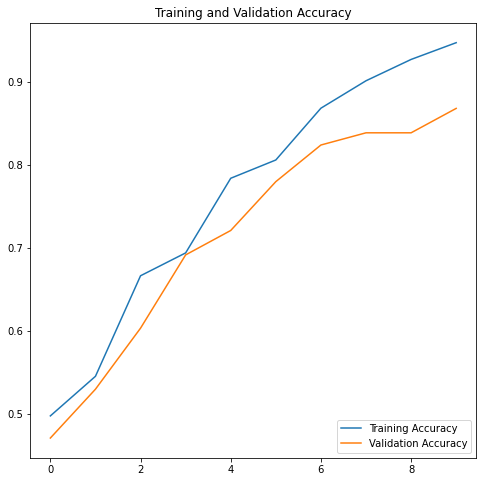

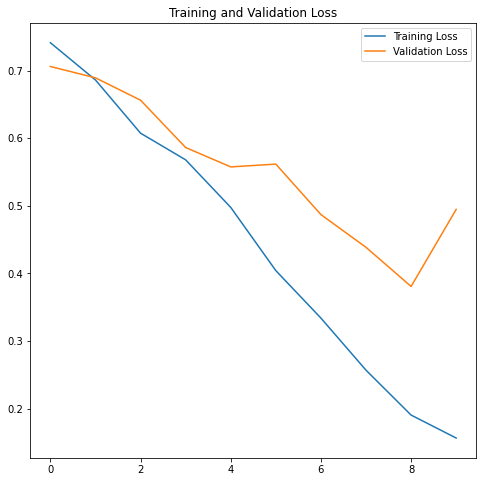

Best val acc:  0.8676470518112183


In [ ]:
show_training_metrics()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[[30  2]
 [ 7 29]]


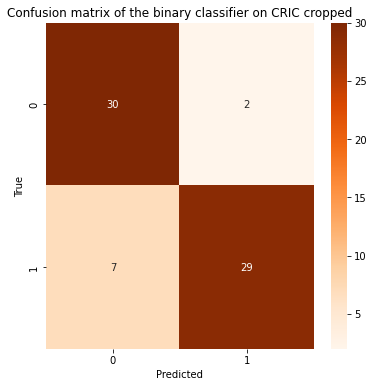

F1 score: 0.8656716417910448


In [ ]:
eval_val_get_preds(valid_ds)


# Binary classification cervix 93

In [ ]:
#set data directory paths
cervix93_dir = os.path.join(raw_data_folder,'cervix_93/cervix_93/')
os.chdir(cervix93_dir)

In [ ]:
cervix_93_labels = pd.read_csv(os.path.join(cervix93_dir,'labels.csv'))

In [ ]:
cervix_93_labels.head()

frame label  set
0  frame000     H    0
1  frame001     H    0
2  frame002     H    1
3  frame003     H    1
4  frame004     H    0

In [ ]:
cervix_93_labels.loc[cervix_93_labels['frame'] == 'frame000'].label

0    H
Name: label, dtype: object

In [ ]:
#get paths to images and associated labels


def get_files_labels(input_dir):
    image_paths = [] #empty list to store filepaths
    labels = [] # empty list to store image labels
    #labels_zero = [0]*10 # initialise array of zeros, so we can use this to apply one-hot encoding to the image labels

    for root, dirnames, filenames in os.walk(input_dir,topdown=True): #look at all folders and subfolders and get the filenames
      for dir in dirnames:
        if dir.split('_')[-1] == 'stack':
          print('Looking at :',dir)
          files_in_dir = os.listdir(dir)
          temp_frame = dir.split('/')[-1].split('_')[-2]
          temp_label = cervix_93_labels.loc[cervix_93_labels['frame'] == temp_frame].label #get label from pandas df
          for filename in files_in_dir: #loop through filenames
            if filename != 'labels.csv':
              temp_path = os.path.join(root,dir,filename) # temp filepath
              # print(temp_path)
              image_paths.append(temp_path) # add to image paths list
              # if looking at other datasets, below line needs to be modified to get image label from filepath
              labels.append(temp_label) # add label to label list

      #convert list into array
    image_paths_array = np.array(image_paths)
    labels_array = np.array(labels)
    # labels_array = labels_array.astype(int)
    return image_paths_array, labels_array


all_image_paths , all_image_labels = get_files_labels(cervix93_dir)

for x in range(10):
  print(f'{all_image_paths[x]}     {all_image_labels[x]}')




Looking at : frame009_stack
Looking at : frame056_stack
Looking at : frame017_stack
Looking at : frame014_stack
Looking at : frame076_stack
Looking at : frame038_stack
Looking at : frame079_stack
Looking at : frame047_stack
Looking at : frame039_stack
Looking at : frame035_stack
Looking at : frame054_stack
Looking at : frame024_stack
Looking at : frame074_stack
Looking at : frame067_stack
Looking at : frame072_stack
Looking at : frame050_stack
Looking at : frame033_stack
Looking at : frame043_stack
Looking at : frame030_stack
Looking at : frame089_stack
Looking at : frame057_stack
Looking at : frame044_stack
Looking at : frame066_stack
Looking at : frame027_stack
Looking at : frame064_stack
Looking at : frame004_stack
Looking at : frame078_stack
Looking at : frame085_stack
Looking at : frame022_stack
Looking at : frame037_stack
Looking at : frame031_stack
Looking at : frame092_stack
Looking at : frame013_stack
Looking at : frame051_stack
Looking at : frame002_stack
Looking at : frame00

In [ ]:
print('all images:')
image_label_list = all_image_labels

count_classes(image_label_list)

all images:
total images =  1602
Counter({'L': 820, 'H': 522, 'N': 260})


In [ ]:
def label_mapping(x):
  if x == 'N':
    return 0
  else:
    return 1

def convert_labels(label_list):
  vf = np.vectorize(label_mapping)
  new_label_list = vf(label_list).astype(int)
  return new_label_list.reshape(-1)

new_labels = convert_labels(all_image_labels)
print(new_labels)
count_classes(new_labels)

[1 1 1 ... 1 1 1]
total images =  1602
Counter({1: 1342, 0: 260})


In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = make_train_test_splits(all_image_paths,new_labels,upsample=True)

file_path_indices_ones  [   0    1    2 ... 1599 1600 1601]
file_path_ones  ['/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/cervix_93/cervix_93/frame009_stack/fov006.png'
 '/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/cervix_93/cervix_93/frame009_stack/fov015.png'
 '/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/cervix_93/cervix_93/frame009_stack/fov003.png'
 ...
 '/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/cervix_93/cervix_93/frame055_stack/fov009.png'
 '/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/cervix_93/cervix_93/frame055_stack/fov007.png'
 '/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/cervix_93/cervix_9

In [ ]:
train_ds_opt , valid_ds_opt, test_ds = make_tf_datasets(x_train, y_train, x_val, y_val, x_test, y_test, BATCH_SIZE=32)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


tf.Tensor([90 90  1], shape=(3,), dtype=int32)
label  tf.Tensor(0.0, shape=(), dtype=float64)


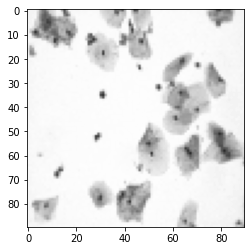

tf.Tensor([90 90  1], shape=(3,), dtype=int32)
label  tf.Tensor(1.0, shape=(), dtype=float64)


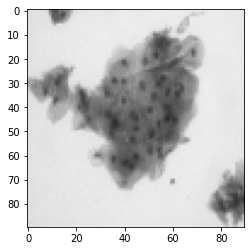

tf.Tensor([90 90  1], shape=(3,), dtype=int32)
label  tf.Tensor(1.0, shape=(), dtype=float64)


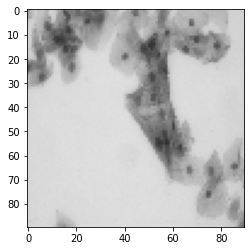

tf.Tensor([90 90  1], shape=(3,), dtype=int32)
label  tf.Tensor(1.0, shape=(), dtype=float64)


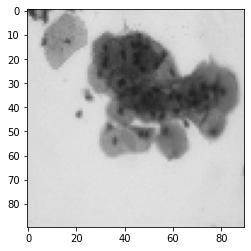

tf.Tensor([90 90  1], shape=(3,), dtype=int32)
label  tf.Tensor(1.0, shape=(), dtype=float64)


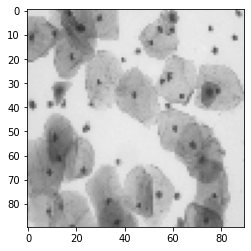

tf.Tensor([90 90  1], shape=(3,), dtype=int32)
label  tf.Tensor(1.0, shape=(), dtype=float64)


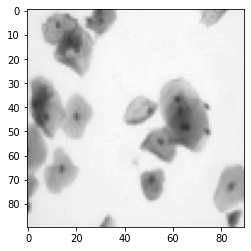

tf.Tensor([90 90  1], shape=(3,), dtype=int32)
label  tf.Tensor(1.0, shape=(), dtype=float64)


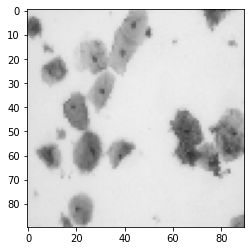

tf.Tensor([90 90  1], shape=(3,), dtype=int32)
label  tf.Tensor(1.0, shape=(), dtype=float64)


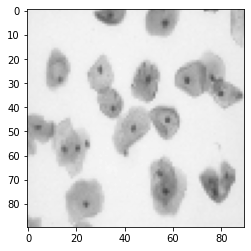

tf.Tensor([90 90  1], shape=(3,), dtype=int32)
label  tf.Tensor(1.0, shape=(), dtype=float64)


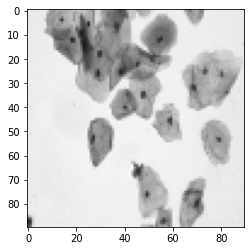

tf.Tensor([90 90  1], shape=(3,), dtype=int32)
label  tf.Tensor(0.0, shape=(), dtype=float64)


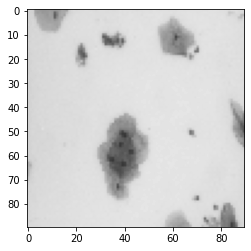

(32, 90, 90, 1)
(32,)


In [ ]:
view_train_images(train_ds_opt)
check_batch_dims(train_ds_opt)

In [ ]:
model, history = define_compile_train_model(train_ds_opt,valid_ds_opt)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 90, 90, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 90, 90, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 64)        1

2022/08/17 14:58:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6e81589fc1734dda8a0923ee730c5271', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
68/68 - 283s - loss: 0.6791 - accuracy: 0.6139 - val_loss: 0.6213 - val_accuracy: 0.5933 - 283s/epoch - 4s/step
Epoch 2/10
68/68 - 1s - loss: 0.3091 - accuracy: 0.8845 - val_loss: 0.1129 - val_accuracy: 0.9664 - 1s/epoch - 21ms/step
Epoch 3/10
68/68 - 1s - loss: 0.0351 - accuracy: 0.9912 - val_loss: 0.0048 - val_accuracy: 1.0000 - 1s/epoch - 21ms/step
Epoch 4/10
68/68 - 1s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000 - 1s/epoch - 21ms/step
Epoch 5/10
68/68 - 1s - loss: 6.6254e-04 - accuracy: 1.0000 - val_loss: 4.6846e-04 - val_accuracy: 1.0000 - 1s/epoch - 21ms/step
Epoch 6/10
68/68 - 1s - loss: 2.8842e-04 - accuracy: 1.0000 - val_loss: 2.4618e-04 - val_accuracy: 1.0000 - 1s/epoch - 21ms/step


2022/08/17 15:04:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


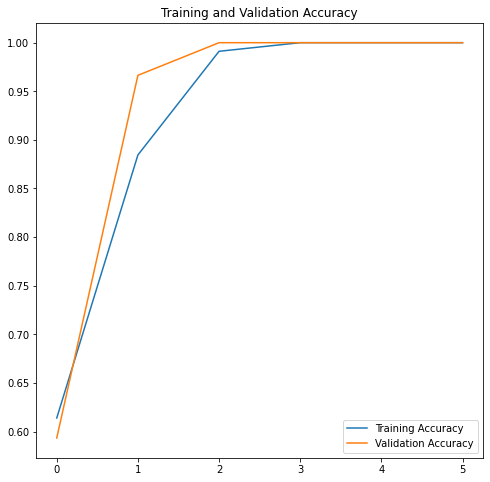

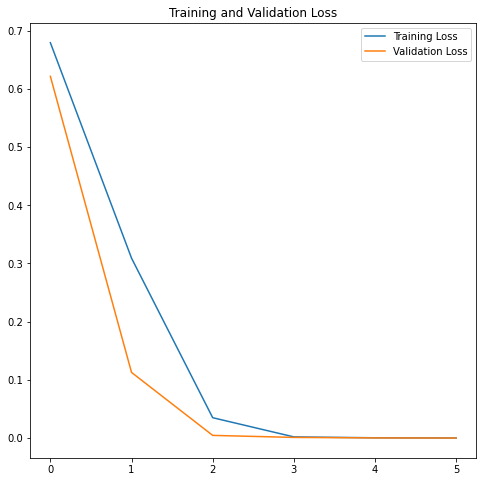

Best val acc:  1.0


In [ ]:
show_training_metrics()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[[124   0]
 [  0 144]]


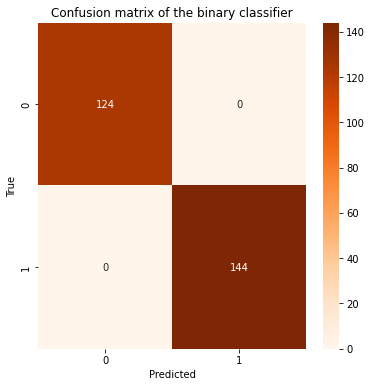

F1 score: 1.0


In [ ]:
eval_val_get_preds(valid_ds_opt)

# Mendeley binary classification

In [ ]:
#set data directory paths
mend_dir = os.path.join(raw_data_folder,'mendeley_hussain_liquid_based_cytology')
os.chdir(mend_dir)

In [ ]:
#get paths to images and associated labels
def get_files_labels(input_dir):
    image_paths = [] #empty list to store filepaths
    labels = [] # empty list to store image labels
    #labels_zero = [0]*10 # initialise array of zeros, so we can use this to apply one-hot encoding to the image labels

    for root, dirnames, filenames in os.walk(input_dir,topdown=True): #look at all folders and subfolders and get the filenames
      for dir in dirnames:
        print('Looking at :',dir)
        files_in_dir = os.listdir(dir)
        for filename in files_in_dir: #loop through filenames
          if filename == 'Results.csv':
            pass
          else:
            temp_path = os.path.join(root,dir,filename) # temp filepath
            #print(temp_path)
            image_paths.append(temp_path) # add to image paths list
            # if looking at other datasets, below line needs to be modified to get image label from filepath
            temp_label = filename.split('_')[0]
            labels.append(temp_label) # add label to label list

      #convert list into array
    image_paths_array = np.array(image_paths)
    labels_array = np.array(labels)
    # labels_array = labels_array.astype(int)
    return image_paths_array, labels_array


all_image_paths , all_image_labels = get_files_labels(mend_dir)

for x in range(10):
  print(f'{all_image_paths[x]}     {all_image_labels[x]}')




Looking at : High squamous intra-epithelial lesion
Looking at : Negative for Intraepithelial malignancy
Looking at : Low squamous intra-epithelial lesion
Looking at : Squamous cell carcinoma
/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/mendeley_hussain_liquid_based_cytology/High squamous intra-epithelial lesion/HSIL_6 (3).jpg     HSIL
/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/mendeley_hussain_liquid_based_cytology/High squamous intra-epithelial lesion/HSIL_10 (17).jpg     HSIL
/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/mendeley_hussain_liquid_based_cytology/High squamous intra-epithelial lesion/HSIL_10 (8).jpg     HSIL
/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/mendeley_hussain_liquid_based_cytology/High squamous intra-epitheli

In [ ]:
print('all images:')
image_label_list = all_image_labels

count_classes(image_label_list)

all images:
total images =  962
Counter({'NL': 612, 'HSIL': 163, 'LSIL': 113, 'scc': 48, 'SCC': 26})


In [ ]:
def label_mapping(x):
  if x == 'NL':
    return 0
  else:
    return 1

def convert_labels(label_list):
  vf = np.vectorize(label_mapping)
  new_label_list = vf(label_list).astype(int)
  return new_label_list.reshape(-1)

new_labels = convert_labels(all_image_labels)
print(new_labels)
count_classes(new_labels)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = make_train_test_splits(all_image_paths,new_labels,upsample=True)

file_path_indices_ones  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791
 792 793 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809
 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827
 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845
 846 847 848 849 850 851 85

In [ ]:
train_ds_opt , valid_ds_opt, test_ds = make_tf_datasets(x_train, y_train, x_val, y_val, x_test, y_test, BATCH_SIZE=32)


tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(0.0, shape=(), dtype=float64)


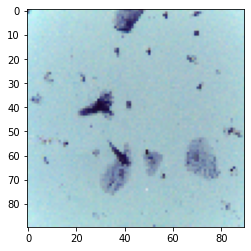

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(1.0, shape=(), dtype=float64)


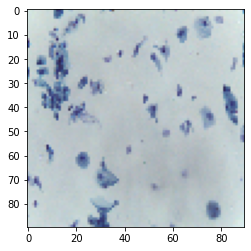

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(0.0, shape=(), dtype=float64)


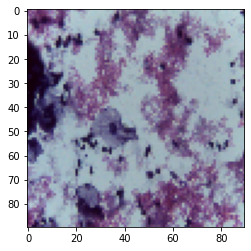

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(0.0, shape=(), dtype=float64)


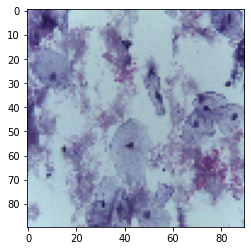

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(1.0, shape=(), dtype=float64)


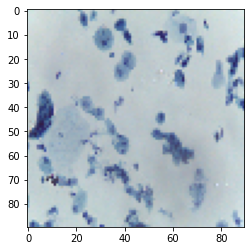

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(1.0, shape=(), dtype=float64)


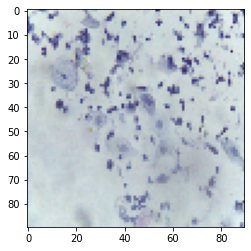

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(1.0, shape=(), dtype=float64)


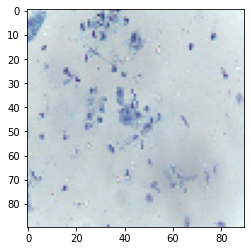

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(0.0, shape=(), dtype=float64)


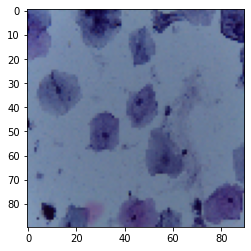

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(1.0, shape=(), dtype=float64)


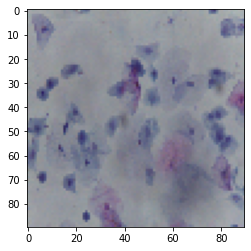

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(0.0, shape=(), dtype=float64)


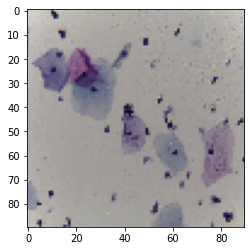

(32, 90, 90, 3)
(32,)


In [ ]:
view_train_images(train_ds_opt)
check_batch_dims(train_ds_opt)

In [ ]:
model, history = define_compile_train_model(train_ds_opt,valid_ds_opt)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 90, 90, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 90, 90, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 64)        1

2022/08/17 15:45:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7e121f931a874d9da5096e058b104ad9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
31/31 - 61s - loss: 0.6582 - accuracy: 0.6313 - val_loss: 0.5833 - val_accuracy: 0.6721 - 61s/epoch - 2s/step
Epoch 2/10
31/31 - 1s - loss: 0.4870 - accuracy: 0.7487 - val_loss: 0.3683 - val_accuracy: 0.8197 - 708ms/epoch - 23ms/step
Epoch 3/10
31/31 - 1s - loss: 0.2390 - accuracy: 0.8999 - val_loss: 0.1590 - val_accuracy: 0.9344 - 712ms/epoch - 23ms/step
Epoch 4/10
31/31 - 1s - loss: 0.1091 - accuracy: 0.9683 - val_loss: 0.0585 - val_accuracy: 0.9754 - 734ms/epoch - 24ms/step
Epoch 5/10
31/31 - 1s - loss: 0.0778 - accuracy: 0.9683 - val_loss: 0.1178 - val_accuracy: 0.9180 - 670ms/epoch - 22ms/step
Epoch 6/10
31/31 - 1s - loss: 0.0626 - accuracy: 0.9785 - val_loss: 0.0533 - val_accuracy: 0.9754 - 692ms/epoch - 22ms/step
Epoch 7/10
31/31 - 1s - loss: 0.0512 - accuracy: 0.9826 - val_loss: 0.0273 - val_accuracy: 0.9836 - 704ms/epoch - 23ms/step
Epoch 8/10
31/31 - 1s - loss: 0.0160 - accuracy: 0.9969 - val_loss: 0.0076 - val_accuracy: 1.0000 - 695ms/epoch - 22ms/step
Epoch 9/10


2022/08/17 15:46:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


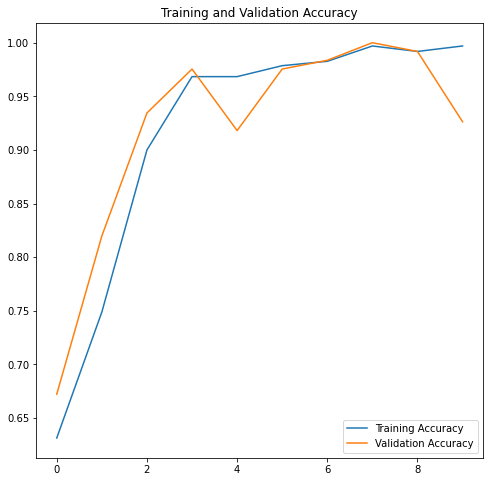

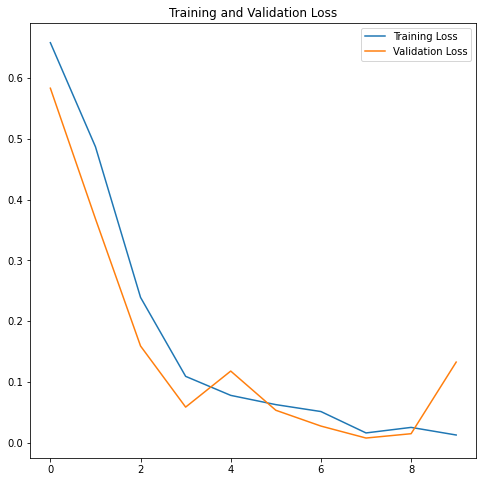

Best val acc:  1.0


In [ ]:
show_training_metrics()

[[64  0]
 [ 9 49]]


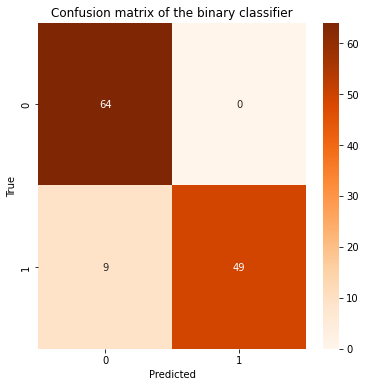

F1 score: 0.9158878504672897


In [ ]:
eval_val_get_preds(valid_ds_opt)

# CDetector binary classification


In [ ]:
#set data directory paths
cdetector_dir = os.path.join(raw_data_folder,'CDetector')
os.chdir(raw_data_folder)

In [ ]:
cdetector_dir

'/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/CDetector'

In [ ]:
!mkdir /content/data/CDetector
!cp -r /content/drive/MyDrive/CDetector/dataset/* /content/data/CDetector
!cd data/CDetector && unzip train.zip
!rm data/CDetector/train.zip
!cd data/CDetector && unzip test.zip
!rm data/CDetector/test.zip

mkdir: cannot create directory ‘/content/data/CDetector’: No such file or directory
cp: cannot stat '/content/drive/MyDrive/CDetector/dataset/*': No such file or directory
/bin/bash: line 0: cd: data/CDetector: No such file or directory
rm: cannot remove 'data/CDetector/train.zip': No such file or directory
/bin/bash: line 0: cd: data/CDetector: No such file or directory
rm: cannot remove 'data/CDetector/test.zip': No such file or directory


In [ ]:
#get paths to images and associated labels
def get_files_labels(input_dir):
    image_paths = [] #empty list to store filepaths
    labels = [] # empty list to store image labels
    #labels_zero = [0]*10 # initialise array of zeros, so we can use this to apply one-hot encoding to the image labels

    for root, dirnames, filenames in os.walk(input_dir,topdown=True): #look at all folders and subfolders and get the filenames
      for dir in dirnames:
        print('Looking at :',dir)
        files_in_dir = os.listdir(dir)
        for filename in files_in_dir: #loop through filenames
          if filename == 'Results.csv':
            pass
          else:
            temp_path = os.path.join(root,dir,filename) # temp filepath
            #print(temp_path)
            image_paths.append(temp_path) # add to image paths list
            # if looking at other datasets, below line needs to be modified to get image label from filepath
            temp_label = filename.split('_')[0]
            labels.append(temp_label) # add label to label list

      #convert list into array
    image_paths_array = np.array(image_paths)
    labels_array = np.array(labels)
    # labels_array = labels_array.astype(int)
    return image_paths_array, labels_array


all_image_paths , all_image_labels = get_files_labels(mend_dir)

for x in range(10):
  print(f'{all_image_paths[x]}     {all_image_labels[x]}')




Looking at : High squamous intra-epithelial lesion
Looking at : Negative for Intraepithelial malignancy
Looking at : Low squamous intra-epithelial lesion
Looking at : Squamous cell carcinoma
/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/mendeley_hussain_liquid_based_cytology/High squamous intra-epithelial lesion/HSIL_6 (3).jpg     HSIL
/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/mendeley_hussain_liquid_based_cytology/High squamous intra-epithelial lesion/HSIL_10 (17).jpg     HSIL
/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/mendeley_hussain_liquid_based_cytology/High squamous intra-epithelial lesion/HSIL_10 (8).jpg     HSIL
/content/drive/.shortcut-targets-by-id/1MN_MgyhaHPoUpQYCws4tOpGbXA-NfwN_/Official_Folder_for_CervAi/Data/raw/mendeley_hussain_liquid_based_cytology/High squamous intra-epitheli

In [ ]:
print('all images:')
image_label_list = all_image_labels

count_classes(image_label_list)

all images:
total images =  962
Counter({'NL': 612, 'HSIL': 163, 'LSIL': 113, 'scc': 48, 'SCC': 26})


In [ ]:
def label_mapping(x):
  if x == 'NL':
    return 0
  else:
    return 1

def convert_labels(label_list):
  vf = np.vectorize(label_mapping)
  new_label_list = vf(label_list).astype(int)
  return new_label_list.reshape(-1)

new_labels = convert_labels(all_image_labels)
print(new_labels)
count_classes(new_labels)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = make_train_test_splits(all_image_paths,new_labels,upsample=True)

file_path_indices_ones  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791
 792 793 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809
 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827
 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845
 846 847 848 849 850 851 85

In [ ]:
train_ds_opt , valid_ds_opt, test_ds = make_tf_datasets(x_train, y_train, x_val, y_val, x_test, y_test, BATCH_SIZE=32)


tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(0.0, shape=(), dtype=float64)


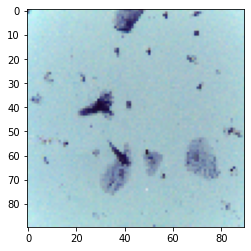

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(1.0, shape=(), dtype=float64)


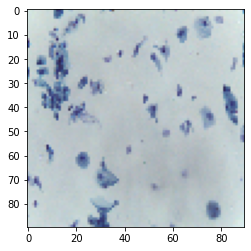

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(0.0, shape=(), dtype=float64)


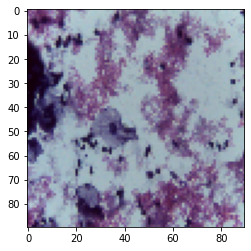

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(0.0, shape=(), dtype=float64)


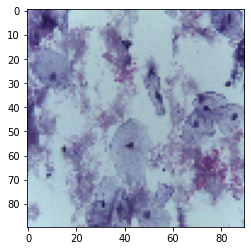

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(1.0, shape=(), dtype=float64)


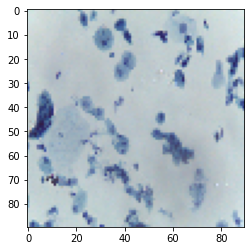

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(1.0, shape=(), dtype=float64)


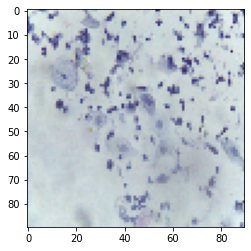

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(1.0, shape=(), dtype=float64)


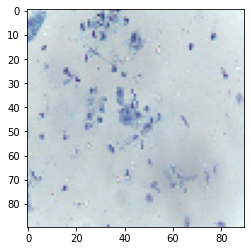

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(0.0, shape=(), dtype=float64)


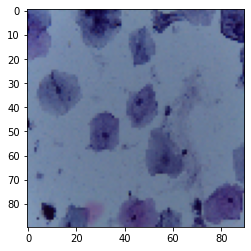

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(1.0, shape=(), dtype=float64)


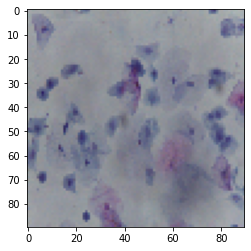

tf.Tensor([90 90  3], shape=(3,), dtype=int32)
label  tf.Tensor(0.0, shape=(), dtype=float64)


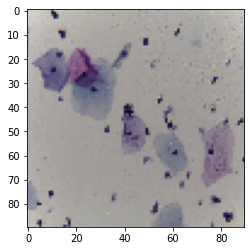

(32, 90, 90, 3)
(32,)


In [ ]:
view_train_images(train_ds_opt)
check_batch_dims(train_ds_opt)

In [ ]:
model, history = define_compile_train_model(train_ds_opt,valid_ds_opt)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 90, 90, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 90, 90, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 64)        1

2022/08/17 15:45:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7e121f931a874d9da5096e058b104ad9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
31/31 - 61s - loss: 0.6582 - accuracy: 0.6313 - val_loss: 0.5833 - val_accuracy: 0.6721 - 61s/epoch - 2s/step
Epoch 2/10
31/31 - 1s - loss: 0.4870 - accuracy: 0.7487 - val_loss: 0.3683 - val_accuracy: 0.8197 - 708ms/epoch - 23ms/step
Epoch 3/10
31/31 - 1s - loss: 0.2390 - accuracy: 0.8999 - val_loss: 0.1590 - val_accuracy: 0.9344 - 712ms/epoch - 23ms/step
Epoch 4/10
31/31 - 1s - loss: 0.1091 - accuracy: 0.9683 - val_loss: 0.0585 - val_accuracy: 0.9754 - 734ms/epoch - 24ms/step
Epoch 5/10
31/31 - 1s - loss: 0.0778 - accuracy: 0.9683 - val_loss: 0.1178 - val_accuracy: 0.9180 - 670ms/epoch - 22ms/step
Epoch 6/10
31/31 - 1s - loss: 0.0626 - accuracy: 0.9785 - val_loss: 0.0533 - val_accuracy: 0.9754 - 692ms/epoch - 22ms/step
Epoch 7/10
31/31 - 1s - loss: 0.0512 - accuracy: 0.9826 - val_loss: 0.0273 - val_accuracy: 0.9836 - 704ms/epoch - 23ms/step
Epoch 8/10
31/31 - 1s - loss: 0.0160 - accuracy: 0.9969 - val_loss: 0.0076 - val_accuracy: 1.0000 - 695ms/epoch - 22ms/step
Epoch 9/10


2022/08/17 15:46:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


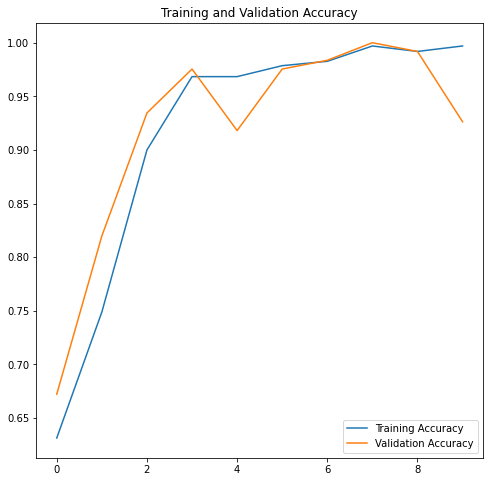

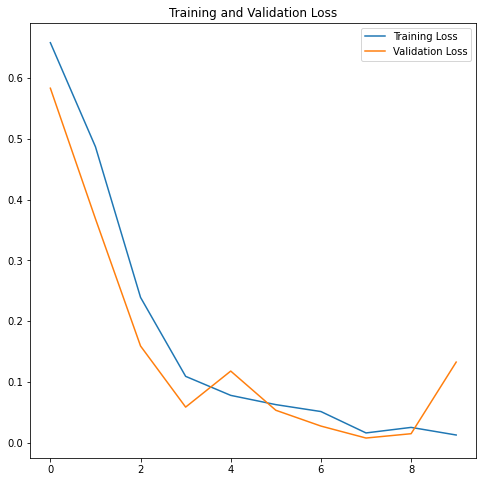

Best val acc:  1.0


In [ ]:
show_training_metrics()

[[64  0]
 [ 9 49]]


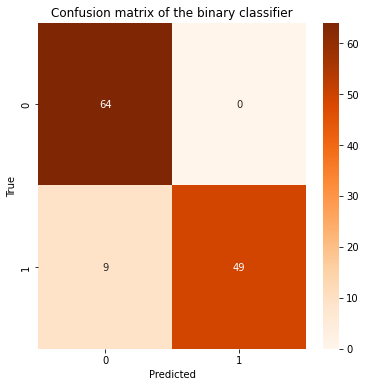

F1 score: 0.9158878504672897


In [ ]:
eval_val_get_preds(valid_ds_opt)